Electron Cooling simulations:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_FWHM(x, y):
    half = np.max(y) / 2.0
    above = np.where(y >= half)[0]
    if len(above) < 2:
        return 0.0
    return x[above[-1]] - x[above[0]]

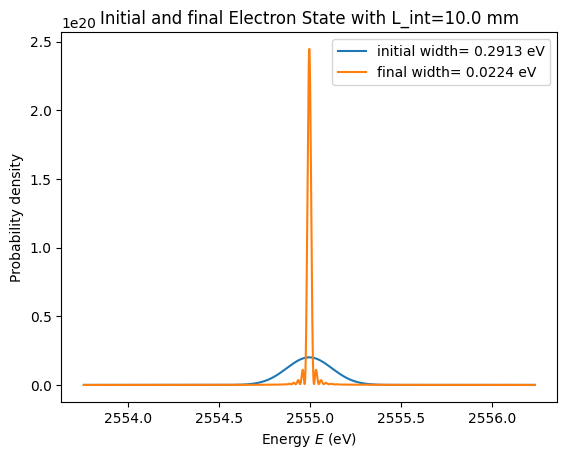

In [3]:
# 1) Physical constants 
c    = 2.99792458e8        # m/s
m    = 9.109383e-31        # kg
e    = 1.60217662e-19      # C
hbar = 1.054571800e-34     # J·s
eps0 = 8.854187817e-12     # F/m
v0     = 0.1 * c                                # electron carrier velocity
E0     = 0.5 * m * v0**2                        # central electron energy (J)

lambda0 = 500e-9                                # central wavelength (m)
omega0  = 2 * np.pi * c / lambda0               # central angular frequency (rad/s)
v_g     = v0                                    # photon group velocity (m/s)

deltaE = 0.05 * hbar * omega0                   # energy spread (J)

k0     = np.sqrt(2 * m * E0) / hbar             # central momentum (1/m)
k0_m_hw     = np.sqrt(2 * m * (E0-hbar *omega0)) / hbar
q0 = k0 - k0_m_hw

# From Phase‐matching expansion (approximation) to fit LINEAR dispersion relations:
recoil = (-1 / (k0 * v0**2))                                  # second‐order term
# Define conversion functions:
def k(E):
    return np.sqrt(2 * m * E) / hbar

lambdaDB = 2 * np.pi  / k0 # de Broglie wavelength (m)
# critical length for cooling (m)
L_critical = (4/np.pi)*lambdaDB*(E0/deltaE)**2  
# L_int = 0.5*L_critical  
L_int = 0.01  # interaction length (m)
T     = L_int / v0     # interaction time (s)

def Energy_from_momentum(k):
    return (hbar * k)**2 / (2 * m)  # Energy from momentum k
N = 2**12
# --- ENERGY GRID
N_E   = N    # number of energy points

E_min = E0 - 10*deltaE
E_max = E0 + 10*deltaE

E_f   = np.linspace(E_min, E_max, N_E)
dE    = E_f[1] - E_f[0]
energy_span = E_max - E_min

δE_f =  E_f - E0

N_ω = N
omega_span = 10 * deltaE / hbar  # Narrow span around ω₀
ω_min = max(omega0 - omega_span/2 , 0*omega0)  # Start from ω₀ - span/2
ω_max = omega0 + omega_span/2   # End at ω₀ + span/2
ω_vec = np.linspace(ω_min, ω_max, N_ω)
dω = ω_vec[1] - ω_vec[0]

δω = ω_vec - omega0

δω_grid, δE_f_grid = np.meshgrid(δω, δE_f)
Delta_PM = k(E0 + δE_f_grid + hbar*δω_grid) - k(E0 + δE_f_grid - hbar*omega0) - (q0 + (δω / v_g) + 0.5 * recoil * δω**2)
rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2))*np.exp(-(δE_f_grid + hbar*δω_grid)**2/2/deltaE**2)*(np.sinc(Delta_PM*L_int/2/np.pi))**2,axis = 1)*dω
rho_f = rho_f/ np.sum(rho_f*dE)  # Normalize the final state probability density
rho_i = np.exp(-δE_f**2/2/deltaE**2)/ np.sqrt(2*np.pi*deltaE**2)  # Initial state probability density
initial_width = compute_FWHM(E_f, rho_i)/e  # Initial width in eV
final_width = compute_FWHM(E_f, rho_f)/e  # Final width in eV

plt.figure()
plt.plot(E_f/e, rho_i, label="initial width= {:.4f} eV".format(initial_width))
plt.plot(E_f/e, rho_f, label="final width= {:.4f} eV".format(final_width))
plt.xlabel("Energy $E$ (eV)")
plt.ylabel("Probability density")
plt.title(f"Initial and final Electron State with L_int={L_int*1000} mm")
plt.legend()
plt.show()

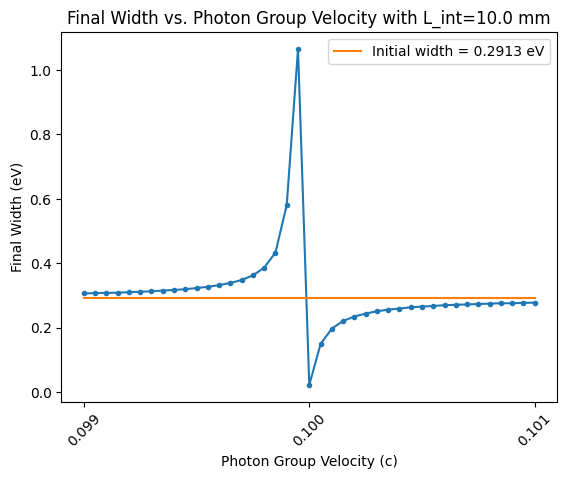

In [ ]:
# Simple Width vs. v_g Scan
v_g_num = 41  # Number of group velocities to test
v_g_vec = np.linspace(0.099, 0.101, v_g_num) * c 
widths_vg = []
for v_g_test in v_g_vec:
    rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2)) * np.exp(-(δE_f_grid + hbar*δω_grid)**2 / (2 * deltaE**2)) * 
                   (np.sinc((k(E0 + δE_f_grid + hbar*δω_grid) - k(E0 + δE_f_grid - hbar*omega0) - (q0 + (δω_grid/ v_g_test) + 0.5 * recoil * δω_grid**2)) * L_int / 2 / np.pi))**2, axis=1) * dω
    rho_f /= np.sum(rho_f * dE)  # Normalize the final state probability density
    widths_vg.append(compute_FWHM(E_f, rho_f) / e)  # Store final width in eV

plt.figure()
plt.plot(v_g_vec / c, widths_vg, '.-')
plt.plot(v_g_vec / c, [initial_width]*v_g_num, label=f'Initial width = {initial_width:.4f} eV')      
plt.xlabel('Photon Group Velocity (c)')
plt.ylabel('Final Width (eV)')
plt.title(f"Final Width vs. Photon Group Velocity with L_int={L_int*1000} mm")
plt.xticks(np.arange(0.099, 0.102, 0.001), rotation=45)
plt.legend()    
plt.show()


In [1]:
# Simple Width vs. Interaction Length Scan
L_num = 11  # Number of interaction lengths to test
L_int_vec = np.linspace(0.00001, 0.001, L_num)  # m
widths_L = []
for L_int_test in L_int_vec:
    rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2))*np.exp(-(δE_f_grid + hbar*δω_grid)**2/2/deltaE**2)*(np.sinc(Delta_PM*(L_int_test/2)/np.pi))**2,axis = 1)*dω
    rho_f = rho_f/ np.sum(rho_f*dE)  # Normalize the final state probability density
    widths_L.append(compute_FWHM(E_f, rho_f)/e)  # Store final width in eV

plt.figure()
plt.plot(L_int_vec*1000, widths_L,'.')
plt.plot(L_int_vec*1000, [initial_width]*L_num, label=f'Initial width = {initial_width:.4f} eV')
plt.xlabel('Interaction Length (mm)')
plt.ylabel('Final Width (eV)')
plt.title(f"Final Width vs. Interaction Length with v_g={v_g/c:.3f} c")
plt.legend()
plt.show()


NameError: name 'np' is not defined

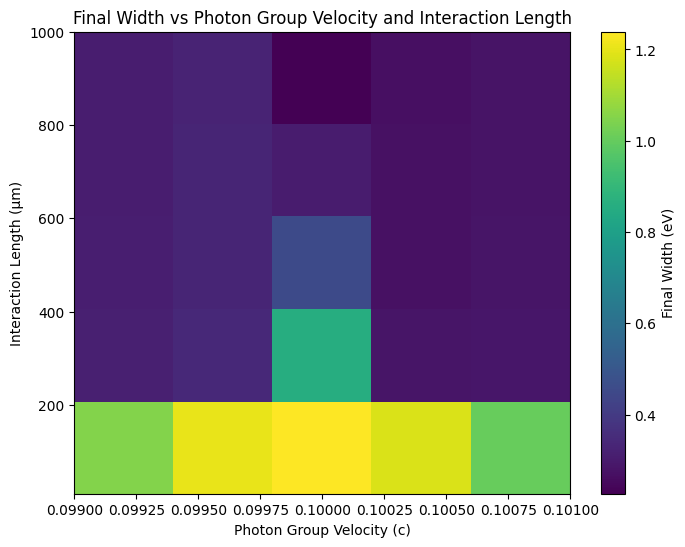

In [ ]:
# 2D plot of widths vs v_g and L_int
L_num = 5  # Number of interaction lengths to test
v_g_num = 5  # Number of group velocities to test
L_int_vec = np.linspace(0.00001, 0.001, L_num)  # m
v_g_vec = np.linspace(0.099, 0.101, v_g_num) * c 

widths_2D = np.zeros((L_num, v_g_num))
for i, L_int_test in enumerate(L_int_vec):
    for j, v_g_test in enumerate(v_g_vec):
        rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2)) * np.exp(-(δE_f_grid + hbar*δω_grid)**2 / (2 * deltaE**2)) * 
                   (np.sinc((k(E0 + δE_f_grid + hbar*δω_grid) - k(E0 + δE_f_grid - hbar*omega0) - 
                             (q0 + (δω_grid/ v_g_test) + 0.5 * recoil * δω_grid**2)) * L_int_test / 2 / np.pi))**2, axis=1) * dω
        rho_f /= np.sum(rho_f * dE)  # Normalize the final state probability density
        widths_2D[i, j] = compute_FWHM(E_f, rho_f) / e  # Store final width in eV
        
# create the 2D plot
plt.figure()
plt.imshow(widths_2D, extent=[v_g_vec.min()/c, v_g_vec.max()/c, L_int_vec.min()*1000, L_int_vec.max()*1000],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Final Width (eV)')
plt.xlabel('Photon Group Velocity (c)')
plt.xticks(np.arange(0.099, 0.102, 0.001), rotation=45)
plt.ylabel('Interaction Length (mm)')
plt.show()


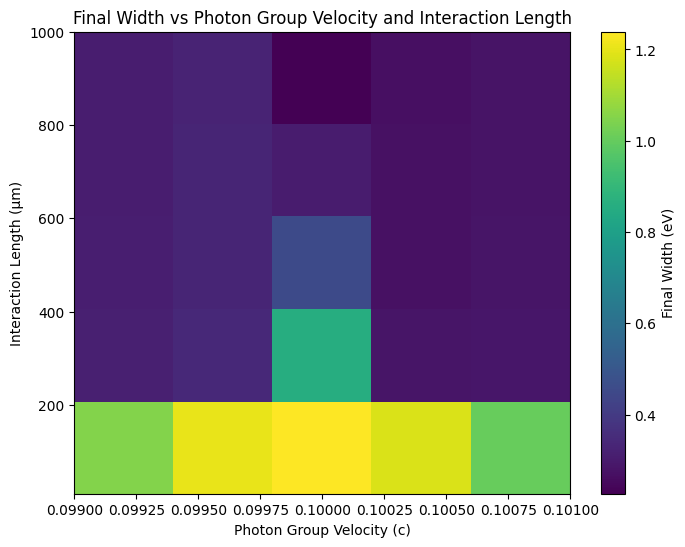

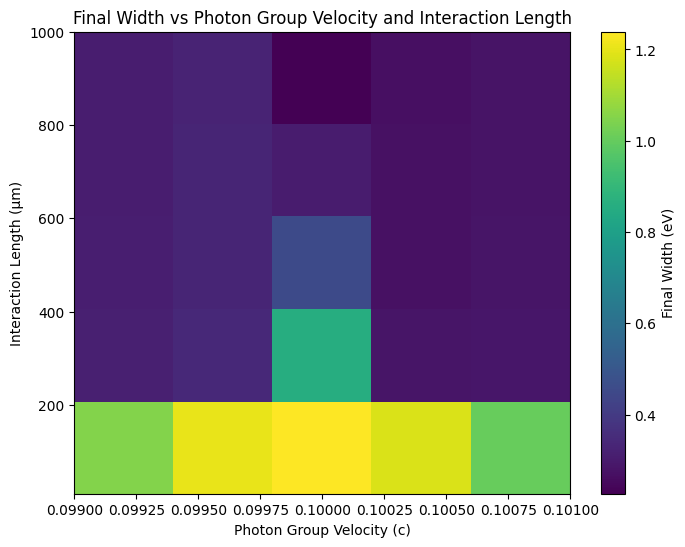

In [ ]:
# different initial widths:
L_num = 5  # Number of interaction lengths to test
v_g_num = 5  # Number of group velocities to test
L_int_vec = np.linspace(0.00001, 0.001, L_num)  # m
initial_widths_vec = [0.1*deltaE,10*deltaE] #eV
v_g_vec = np.linspace(0.099, 0.101, v_g_num) * c 

for initial_width in initial_widths_vec:
    deltaE_test = initial_width * e  # Convert eV to J
    widths_2D = np.zeros((L_num, v_g_num))
    for i, L_int_test in enumerate(L_int_vec):
        for j, v_g_test in enumerate(v_g_vec):
            rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2)) * np.exp(-(δE_f_grid + hbar*δω_grid)**2 / (2 * deltaE**2)) * 
                    (np.sinc((k(E0 + δE_f_grid + hbar*δω_grid) - k(E0 + δE_f_grid - hbar*omega0) - (q0 + (δω_grid/ v_g_test) + 0.5 * recoil * δω_grid**2)) * L_int_test / 2 / np.pi))**2, axis=1) * dω
            rho_f /= np.sum(rho_f * dE)  # Normalize the final state probability density
            widths_2D[i, j] = compute_FWHM(E_f, rho_f) / e  # Store final width in eV
    
    # create the 2D plot
    plt.figure()
    plt.imshow(widths_2D, extent=[v_g_vec.min()/c, v_g_vec.max()/c, L_int_vec.min()*1000, L_int_vec.max()*1000],
            origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Final Width (eV)')
    plt.xlabel('Photon Group Velocity (c)')
    plt.xticks(np.arange(0.099, 0.102, 0.001), rotation=45)
    plt.ylabel('Interaction Length (mm)')
    plt.title(f'Final Width vs Photon Group Velocity and Interaction Length\nInitial Width = {initial_width:.4f} eV')
    plt.tight_layout()
    plt.show()
                

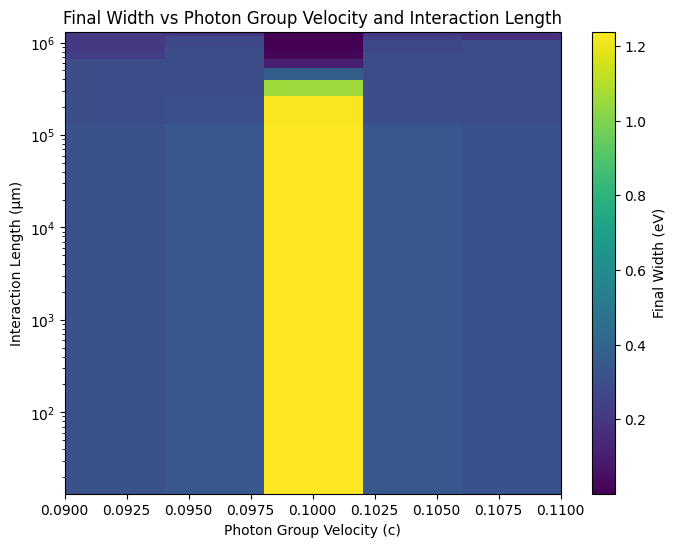

In [ ]:
# log scale L_int 2D graph:
L_num = 10  # Number of interaction lengths to test
v_g_num = 5  # Number of group velocities to test
L_int_vec = np.logspace(np.log10(L_critical*0.001), np.log10(100*L_critical), L_num)  # m - CHANGED TO LOG SCALE
v_g_vec = np.linspace(0.9*v0, 1.1*v0, v_g_num)  

widths_2D = np.zeros((L_num, v_g_num))

for i, L_int_test in enumerate(L_int_vec):
    for j, v_g_test in enumerate(v_g_vec):
        rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2)) * np.exp(-(δE_f_grid + hbar*δω_grid)**2 / (2 * deltaE**2)) * 
                   (np.sinc((k(E0 + δE_f_grid + hbar*δω_grid) - k(E0 + δE_f_grid - hbar*omega0) - (q0 + (δω_grid/ v_g_test) + 0.5 * recoil * δω_grid**2)) * L_int_test / 2 / np.pi))**2, axis=1) * dω
        rho_f /= np.sum(rho_f * dE)  # Normalize the final state probability density
        widths_2D[i, j] = compute_FWHM(E_f, rho_f) / e  # Store final width in eV
        

# create the 2D plot
plt.figure()
plt.imshow(widths_2D, extent=[v_g_vec.min()/c, v_g_vec.max()/c, L_int_vec.min()*1000, L_int_vec.max()*1000],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Final Width (eV)')
plt.xlabel('Photon Group Velocity (c)')
plt.xticks(np.arange(0.099, 0.102, 0.001), rotation=45)
plt.ylabel('Interaction Length logscale (mm)')
plt.yscale('log')  
plt.title('Final Width vs Photon Group Velocity and Interaction Length (log scale)')
plt.tight_layout()
plt.show()